In [ ]:
!pip install langgraph langchain-groq langchain-core requests python-dotenv

In [ ]:
import os
import json
import requests
from typing import TypedDict, Annotated, Sequence
from datetime import datetime
import operator

from langchain_groq import ChatGroq
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage
from langchain_core.tools import tool
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langchain_groq import ChatGroq

In [ ]:

groq_api_key = "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"

llm = ChatGroq(model="openai/gpt-oss-20b",
               temperature=0,
               max_tokens=1024,
               groq_api_key=groq_api_key)


@tool
def get_weather(city: str) -> str:
    """
    Get current weather information for a city.
    Uses the wttr.in API (no API key required).

    Args:
        city: Name of the city to get weather for

    Returns:
        Weather information as a string
    """
    try:
        url = f"https://wttr.in/{city}?format=j1"
        response = requests.get(url, timeout=10)
        response.raise_for_status()

        data = response.json()
        current = data['current_condition'][0]

        weather_info = f"""
Weather in {city}:
- Temperature: {current['temp_C']}°C (feels like {current['FeelsLikeC']}°C)
- Condition: {current['weatherDesc'][0]['value']}
- Humidity: {current['humidity']}%
- Wind: {current['windspeedKmph']} km/h
        """
        return weather_info.strip()
    except Exception as e:
        return f"Error fetching weather data: {str(e)}"


@tool
def get_exchange_rate(from_currency: str, to_currency: str) -> str:
    """
    Get the current exchange rate between two currencies.
    Uses the exchangerate-api.com (free tier, no key required for basic usage).

    Args:
        from_currency: Source currency code (e.g., 'USD')
        to_currency: Target currency code (e.g., 'EUR')

    Returns:
        Exchange rate information
    """
    try:
        from_currency = from_currency.upper()
        to_currency = to_currency.upper()

        url = f"https://api.exchangerate-api.com/v4/latest/{from_currency}"
        response = requests.get(url, timeout=10)
        response.raise_for_status()

        data = response.json()

        if to_currency in data['rates']:
            rate = data['rates'][to_currency]
            return f"1 {from_currency} = {rate:.4f} {to_currency}"
        else:
            return f"Currency {to_currency} not found"
    except Exception as e:
        return f"Error fetching exchange rate: {str(e)}"


@tool
def get_random_fact(category: str = "general") -> str:
    """
    Get a random interesting fact.
    Uses the API Ninjas Facts API.

    Args:
        category: Category of fact (not strictly enforced by free API)

    Returns:
        A random fact
    """
    try:
        url = "https://uselessfacts.jsph.pl/random.json?language=en"
        response = requests.get(url, timeout=10)
        response.raise_for_status()

        data = response.json()
        return f"Random Fact: {data['text']}"
    except Exception as e:
        return f"Error fetching random fact: {str(e)}"


@tool
def get_current_time(timezone: str = "UTC") -> str:
    """
    Get the current time.

    Args:
        timezone: Timezone name (e.g., 'UTC', 'America/New_York')

    Returns:
        Current time information
    """
    try:
        current_time = datetime.now()
        return f"Current time ({timezone}): {current_time.strftime('%Y-%m-%d %H:%M:%S')}"
    except Exception as e:
        return f"Error getting time: {str(e)}"


tools = [get_weather, get_exchange_rate, get_random_fact, get_current_time]

llm_with_tools = llm.bind_tools(tools)



In [ ]:
class AgentState(TypedDict):
    """
    The state of our agent.
    Messages are accumulated over time using the add_messages reducer.
    """
    messages: Annotated[Sequence[BaseMessage], operator.add]

def call_model(state: AgentState):
    """
    Node that calls the LLM with tools.
    The LLM decides whether to use tools or respond directly.
    """
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}


def should_continue(state: AgentState):
    """
    Conditional edge function that determines if we should continue or end.
    If the last message has tool calls, we continue to execute tools.
    Otherwise, we end.
    """
    messages = state["messages"]
    last_message = messages[-1]

    # If there are no tool calls, we're done
    if not last_message.tool_calls:
        return "end"
    # Otherwise, continue to execute tools
    return "continue"

In [ ]:
def create_agent():
    """
    Creates and compiles the LangGraph agent.

    The graph flow:
    1. User input -> call_model (LLM decides action)
    2. If tools needed -> execute tools -> call_model again
    3. If no tools needed -> END (return response)
    """

    # Initialize the graph
    workflow = StateGraph(AgentState)

    # Add nodes
    workflow.add_node("agent", call_model)
    workflow.add_node("tools", ToolNode(tools))

    # Set the entry point
    workflow.set_entry_point("agent")

    # Add conditional edges
    workflow.add_conditional_edges(
        "agent",
        should_continue,
        {
            "continue": "tools",
            "end": END
        }
    )

    # Add edge from tools back to agent
    workflow.add_edge("tools", "agent")

    # Compile the graph with memory
    memory = MemorySaver()
    agent = workflow.compile(checkpointer=memory)

    return agent

In [ ]:
def print_messages(messages):
    """Helper function to print messages in a readable format."""
    for msg in messages:
        if isinstance(msg, HumanMessage):
            print(f"\n User: {msg.content}")
        elif isinstance(msg, AIMessage):
            if msg.content:
                print(f"\n Assistant: {msg.content}")
            if hasattr(msg, 'tool_calls') and msg.tool_calls:
                print(f"    Using tools: {[tc['name'] for tc in msg.tool_calls]}")
        elif isinstance(msg, ToolMessage):
            print(f"    Tool result: {msg.content[:100]}...")


def run_agent(agent, query: str, thread_id: str = "default"):
    """
    Run the agent with a query.

    Args:
        agent: The compiled LangGraph agent
        query: User's query
        thread_id: Thread ID for conversation memory
    """
    print("\n" + "="*80)
    print(f"Query: {query}")
    print("="*80)

    config = {"configurable": {"thread_id": thread_id}}

    # Stream the agent's execution
    for event in agent.stream(
        {"messages": [HumanMessage(content=query)]},
        config=config,
        stream_mode="values"
    ):
        print_messages(event["messages"][-1:])

    return event["messages"][-1].content


In [ ]:
print(" Weather, Exchange Rates, Random Facts, Time")
agent = create_agent()

 Weather, Exchange Rates, Random Facts, Time


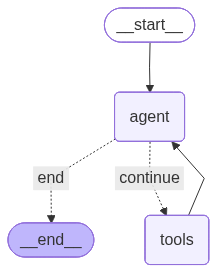

In [ ]:
from IPython.display import Image, display
display(Image(agent.get_graph().draw_mermaid_png()))

In [ ]:
examples = [
    "What's the weather like in London?",
    "What's the exchange rate from USD to EUR?",
    "Tell me a random fact",
    "What's the current time?",
    "Can you check the weather in Tokyo and tell me the exchange rate from JPY to USD?"
]

print("\n\n EXAMPLE QUERIES TO TRY:")
for i, example in enumerate(examples, 1):
    print(f"{i}. {example}")

print("\n\n Running Example Query...")

result = run_agent(
    agent,
    "What's the weather in dhaka and the exchange rate from bdt to USD and whats the current time??",
    thread_id="demo"
)




 EXAMPLE QUERIES TO TRY:
1. What's the weather like in London?
2. What's the exchange rate from USD to EUR?
3. Tell me a random fact
4. What's the current time?
5. Can you check the weather in Tokyo and tell me the exchange rate from JPY to USD?


 Running Example Query...

Query: What's the weather in dhaka and the exchange rate from bdt to USD and whats the current time??

 User: What's the weather in dhaka and the exchange rate from bdt to USD and whats the current time??
    Using tools: ['get_current_time']
    Tool result: Current time (Asia/Dhaka): 2025-10-15 15:48:10...

 Assistant: **Weather in Dhaka (now)**  
- Temperature: **28 °C** (feels like 30 °C)  
- Condition: **Clear**  
- Humidity: **66 %**  
- Wind: **10 km/h**

**Exchange rate**  
- **1 BDT ≈ 0.0082 USD** (Bangladeshi Taka to US Dollar)

**Current time (Asia/Dhaka)**  
- **2025‑10‑15 15:48:10** (local time)
